In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


plt.style.use("../science.mplstyle")

from helpers.physics_functions import bkg_fit_cubic, bkg_fit_ratio, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio
from helpers.evaluation import get_median_percentiles

In [2]:
pickle_save_dir = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/pickles/mix_1_upsilon_iso_oppsign"
train_samesign = False

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"

particle_type = "upsilon_iso"
particle_id = "upsilon"

if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"
    

    

In [3]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)   
    
SB_left = float(workflow[particle_id]["SB_left"])
SR_left = float(workflow[particle_id]["SR_left"])
SR_right = float(workflow[particle_id]["SR_right"])
SB_right = float(workflow[particle_id]["SB_right"])

# Load in the BDT results

In [4]:
num_bootstraps = 50
n_folds = 5

with open(f"{pickle_save_dir}/all_test_data_splits", "rb") as ifile:
    all_test_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir}/all_alt_data_splits", "rb") as ifile:
    all_alt_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir}/all_scores_splits", "rb") as ifile:
    all_scores_splits = pickle.load(ifile)
with open(f"{pickle_save_dir}/all_alt_scores_splits", "rb") as ifile:
    all_alt_scores_splits = pickle.load(ifile)

    
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)

## Plot histograms for a small number of FPR thresholds

In [5]:

    
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01]

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_bootstraps)}

for pseudo_e in range(num_bootstraps):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff





In [6]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True):
    
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "ratio": fit_function = bkg_fit_ratio

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right)


    plt.figure(figsize = (12, 9))
    for t, threshold in enumerate(fpr_thresholds):

        # corrections to SR / SB efficiencies
        filtered_masses = []

        for i_fold in range(n_folds):
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)

        filtered_masses = np.concatenate(filtered_masses)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
        #print("chi2/dof:", chi2/n_dof)
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

        label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,4))+", $S/\sqrt{B}$: "+str(round(significance,4))
        label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


    plt.legend(loc = (1, 0), fontsize = 24)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
    plt.ylabel("Counts", fontsize = 24)

    plt.title(title, fontsize = 24)
    


In [7]:
pseudo_e_to_plot = 0
fit_type = "cubic"

/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


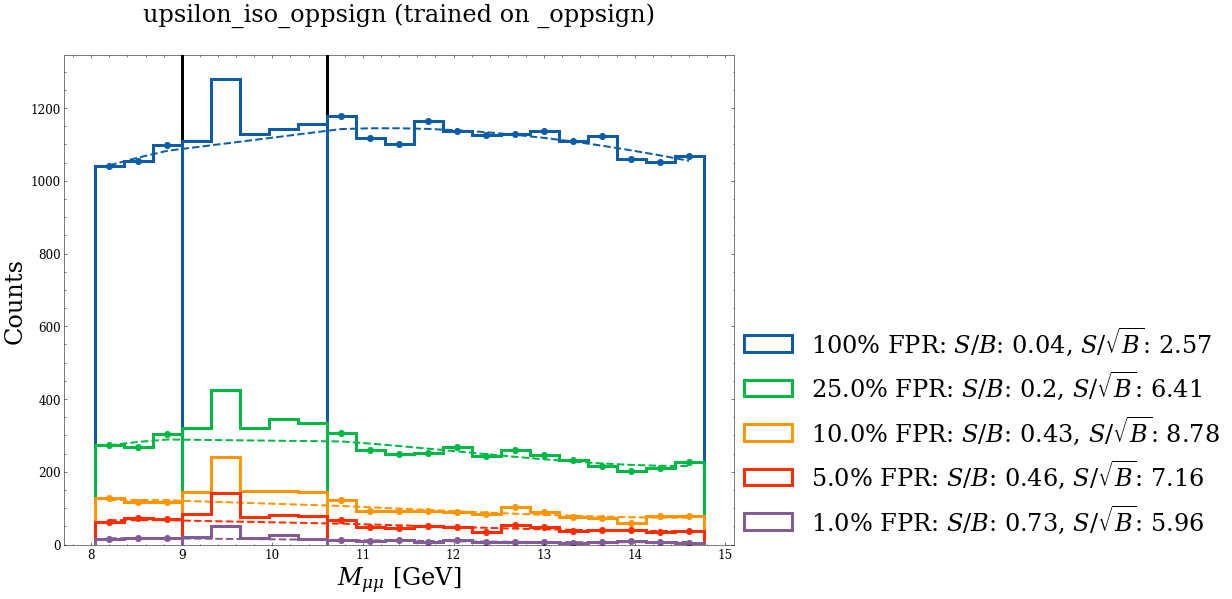

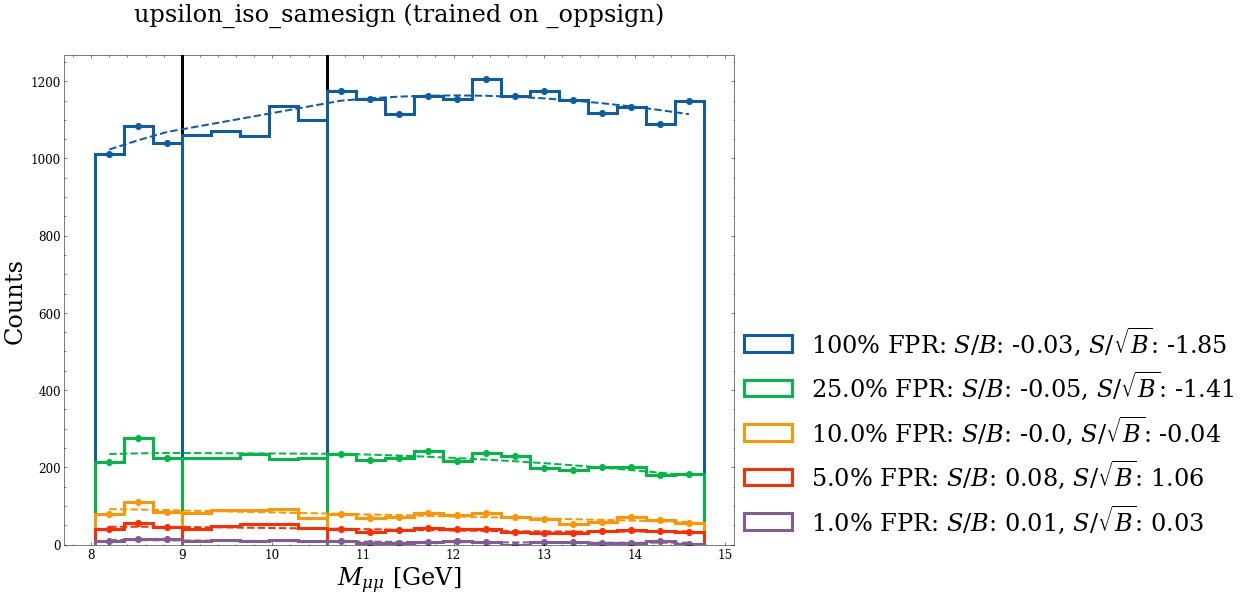

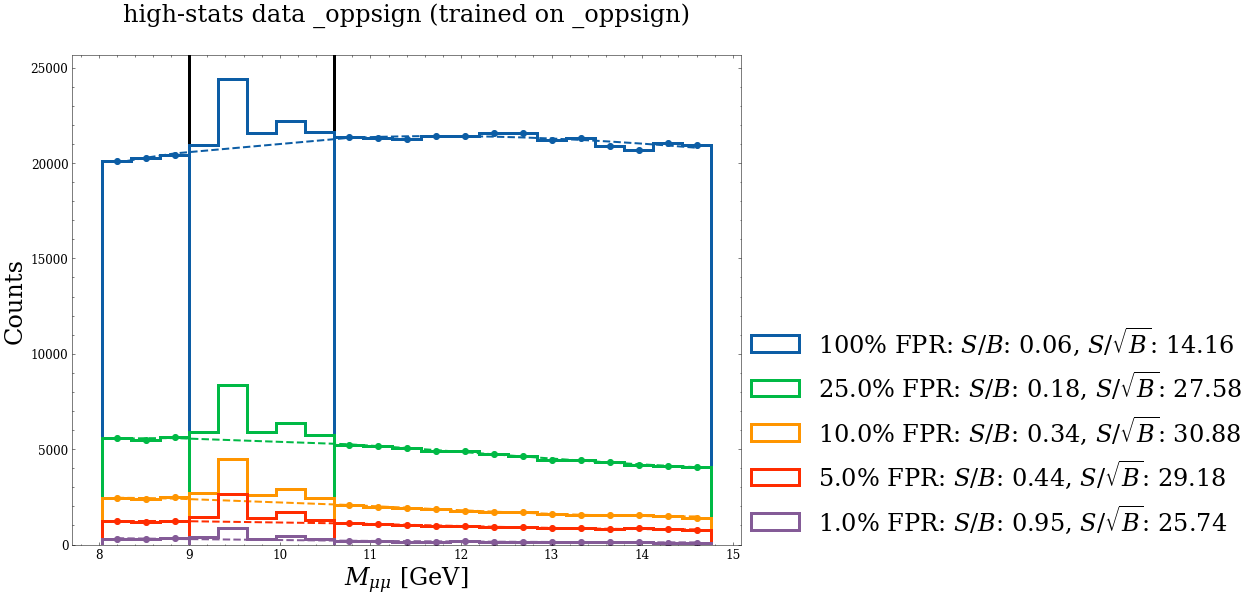

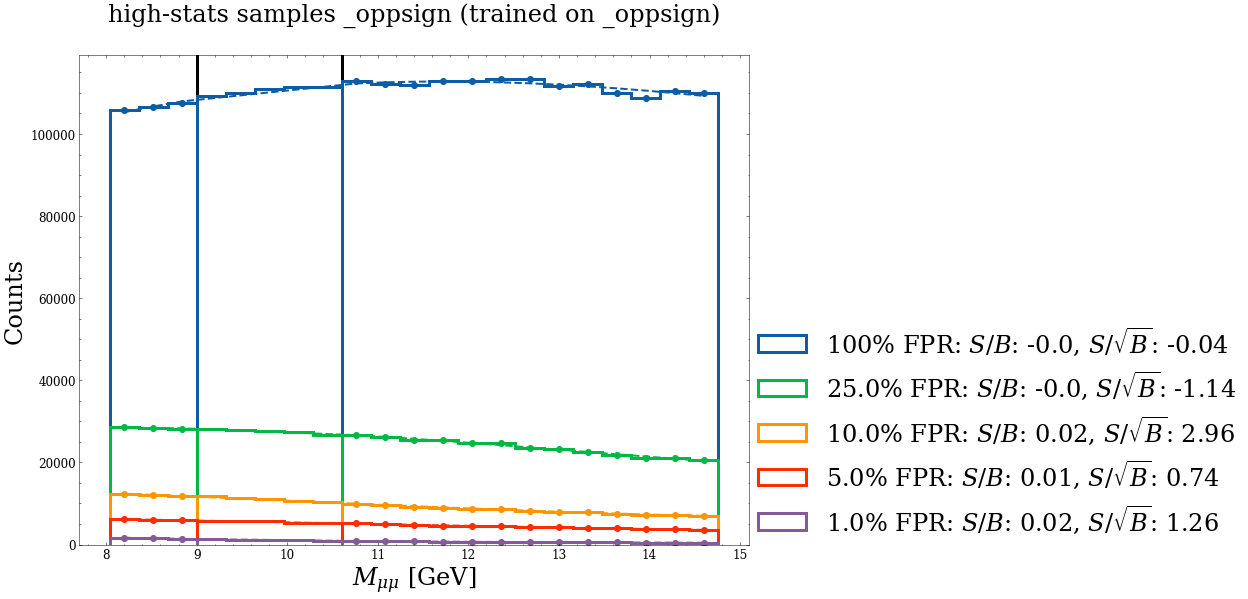

In [8]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n",SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



# Plot ROC

In [9]:
fit_type = "cubic"
fit_function = bkg_fit_cubic

In [10]:
"""
CALCULATE THE ROC CURVES
"""

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right)

fpr_thresholds_finegrained = np.logspace(0, -3, 20)
#fpr_thresholds = np.linspace(1, 0 , 50)

# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_bootstraps)}

for pseudo_e in range(num_bootstraps):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff

        
def get_classifier_metrics_high_stats(dataset_id, score_cutoffs):
    
            
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_bootstraps)), np.empty((fpr_thresholds_finegrained.shape[0], num_bootstraps))

    for pseudo_e in range(num_bootstraps):

        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):

            filtered_masses_bs = []

            for i_fold in range(n_folds):
                loc_true_masses_bs = scaler.inverse_transform(np.array(all_alt_data_splits[pseudo_e][dataset_id][i_fold][:,-1]).reshape(-1,1))
                loc_scores_bs = all_alt_scores_splits[pseudo_e][dataset_id][i_fold]
                # filter top event based on score cutoff
                loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[pseudo_e][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
                filtered_masses_bs.append(loc_filtered_masses_bs)

            filtered_masses_bs = np.concatenate(filtered_masses_bs)
            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, SR_left, SR_right, popt)
            
        
            S_yield[t, pseudo_e] = num_S_expected_in_SR
            B_yield[t, pseudo_e] = num_B_expected_in_SR
            
        
    # calculate summary stats
    TPR = S_yield/S_yield[0,:]
    FPR = B_yield/B_yield[0,:]
    

    ROC = 1.0/FPR

    SIC = TPR/np.sqrt(FPR)
    
    return TPR, FPR, ROC, SIC



In [11]:


TPR, FPR, ROC, SIC = get_classifier_metrics_high_stats("ROC_data", score_cutoffs_finegrained)



On pseudo experiment 1...
On pseudo experiment 2...
On pseudo experiment 3...
On pseudo experiment 4...
On pseudo experiment 5...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 6...
On pseudo experiment 7...
On pseudo experiment 8...
On pseudo experiment 9...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 10...
On pseudo experiment 11...
On pseudo experiment 12...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 13...
On pseudo experiment 14...
On pseudo experiment 15...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 16...
On pseudo experiment 17...
On pseudo experiment 18...
On pseudo experiment 19...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 20...
On pseudo experiment 21...
On pseudo experiment 22...
On pseudo experiment 23...
On pseudo experiment 24...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 25...
On pseudo experiment 26...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 27...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 28...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 29...
On pseudo experiment 30...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 31...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 32...
On pseudo experiment 33...
On pseudo experiment 34...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 35...
On pseudo experiment 36...
On pseudo experiment 37...
On pseudo experiment 38...
On pseudo experiment 39...
On pseudo experiment 40...
On pseudo experiment 41...
On pseudo experiment 42...
On pseudo experiment 43...
On pseudo experiment 44...
On pseudo experiment 45...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 46...


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:96: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 47...
On pseudo experiment 48...
On pseudo experiment 49...
On pseudo experiment 50...


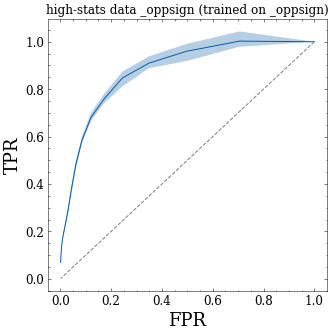

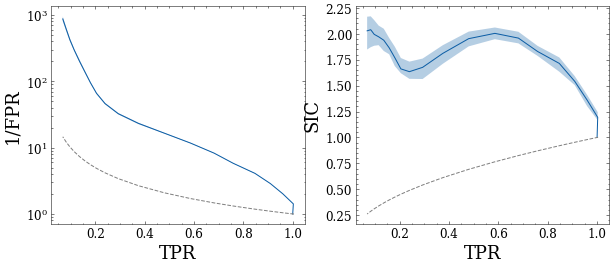

In [12]:
     
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

plt.figure(figsize = (5, 5))
plt.plot(FPR_median, TPR_median)
plt.fill_between(FPR_median, TPR_lower, TPR_upper, alpha = 0.3 )
plt.plot(FPR_median, FPR_median, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"high-stats data _oppsign (trained on {train_data_id_title})")
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (10, 4))


ax[0].plot(TPR_median, ROC_median)
ax[0].fill_between(TPR_median, ROC_lower, ROC_upper, alpha = 0.3 )
ax[0].plot(TPR_median, 1.0/TPR_median, linestyle = "dashed", color = "grey")
ax[0].set_xlabel("TPR")
ax[0].set_ylabel("1/FPR")
ax[0].set_yscale("log")

ax[1].plot(TPR_median, SIC_median)
ax[1].fill_between(TPR_median, SIC_lower, SIC_upper, alpha = 0.3 )
ax[1].plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")
ax[1].set_xlabel("TPR")
ax[1].set_ylabel("SIC")

plt.show()
